&nbsp;

# 16 - Diagnostic dynamique avant apprentissage 

---

&nbsp;

## 1. Introduction

Ce notebook a pour rôle de vérifier que la dynamque sous-jacente des données est cohérente, physiquement plausible et exploitable (avant SciML). Il vient comme une étape de validation avant l'apprentissage des modèles SciML.

L'enjeu central est le suivant. Un modèle d'apprentissage, et plus particulièrement, un réseau de neurones, ne doit pas apprendre une dynamique mal définie ou numériquement instable.

&nbsp;

> #### Pourquoi un diagnostic dynamique ?

Précisément car cela répond au besoin exprimé ci-dessus.

Les approches/modèles SciML cherchent en fait à approximer : 

- Les relations différentielles
- Les champs de vecteurs dynamiques
- Les régimes d'évolution temporels

C'est la force de ce type d'apprentissage. Mais si les données présentent des dérivées mal estimées, des ordres de grandeurs incohérents ou une dynamique dominée par le bruit, alors tout apprentissage provoquerait de perturber grandement la véracité/authenticité de la dynamique de sortie, cela s'accompagnerait de prédictions imprécises.

&nbsp;

---

&nbsp;

## 2. Estimation des dérivées numériques

> #### Les dérivées temporelles sont-elles bien définies ?

Les modèles SciML apprennent souvent des lois différentielles implicites, c'est-à-dire qu'une ou plusieurs variables peuvent être liées à d'autres de manière non-explicite.

Pour vérifier si de mauvaises estimations des dérivées sont d'augures, nous pouvons utiliser certaines méthodes pour estimer les dérivées. Après quelques recherches méthodologiques, l'idée pour estimer semble être de travailler avec plusieurs schémas d'estimations et comparer la cohérence des résultats. On se sert d'une première méthode dite *baseline* comme la *dérivation par différences finies centrées* (voir https://imag.umontpellier.fr/~nicoud/Cours/CSI%20-%20differences%20finies.pdf) (erreur d'approximation relativement importante).


### 2.1 Dérivation par différences finies centrées

Cette première approximation est volontairement peu mathématiquement sophistiquée pour avoir une estimation de "transition" vers des méthodes plus avancées et s'assurer d'une cohérence à plusieurs niveaux de sophistication.

La dérivation par différences finies centrées de notre dynamique est donnée par la formule suivante :

$$
u'(x) \approx  \frac{u(x+h)-u(x-h)}{2h}
$$

Appliquons la à notre état.



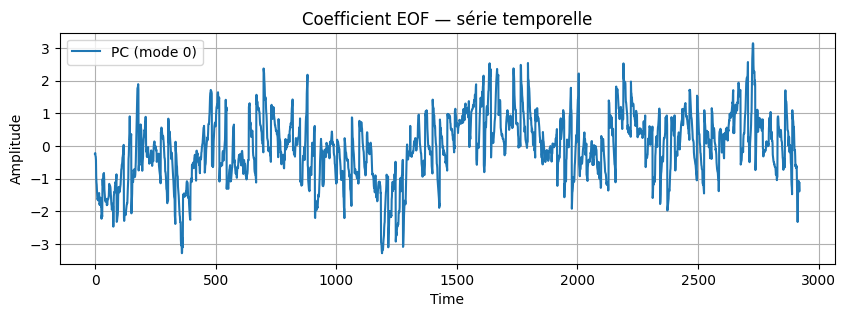

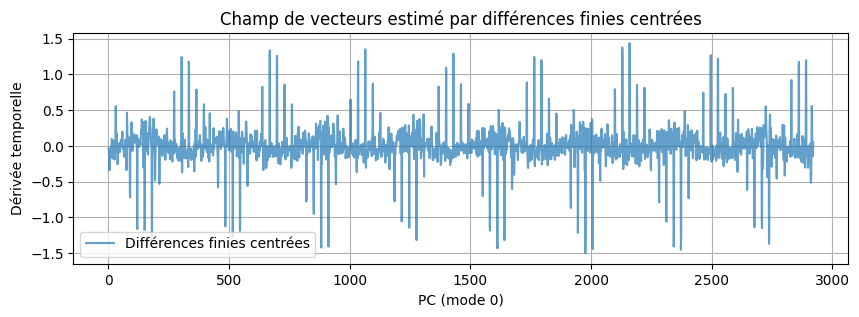

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Basic initialization from the latest processed data
data = np.load("data/processed/sstReducedStateCOPERNICUS20102019Prepared.npz")

PCs = data["PCsTrain"]
t   = data["tTrain"]

dt = float(np.mean(np.diff(t))) # We set the time step (for the derivative scale)

modeId = 0
x0 = PCs[:, modeId]
x1 = PCs[:, modeId + 1]
x2 = PCs[:, modeId + 2]

dxDtFd0 = (x0[2:] - x0[:-2]) / (2 * dt)
dxDtFd1 = (x1[2:] - x1[:-2]) / (2 * dt)
dxDtFd2 = (x2[2:] - x2[:-2]) / (2 * dt)
tFd = t[1:-1]

plt.figure(figsize=(10, 3))
plt.plot(t, x0, label="PC (mode 0)")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Coefficient EOF — série temporelle")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(tFd, dxDtFd0, label="Différences finies centrées", alpha=0.7)
plt.xlabel("PC (mode 0)")
plt.ylabel("Dérivée temporelle")
plt.title("Champ de vecteurs estimé par différences finies centrées")
plt.legend()
plt.grid(True)
plt.show()

On rappelle la forme de notre premier mode pour comparer avec l'estimation de la dérivée temporelle.

On observe une forte variabilité locale conjuguée avec des pics verticaux. Cela donne un aspect "bruit blanc + spikes". La méthode amplifie naturellement les bruits donc les hautes fréquences provoquent ces amplifications. 

Globalement les pics semblent corrélés aux variations rapides du PC 0, l'ordre de grandeur reste borné, il n'y a ni divergences temporelles ni saturation numérique. La dérivée est bruitée mais structurée et sensibles aux variations du PC, c'est ce qu'on attend d'une baseline.

### 2.2 Filtre de Savitzky-Golay

Comparons avec la forme d'une dérivation "régularisée" comme le filtre de Savitzky-Golay qui va limiter l'impact du bruit.

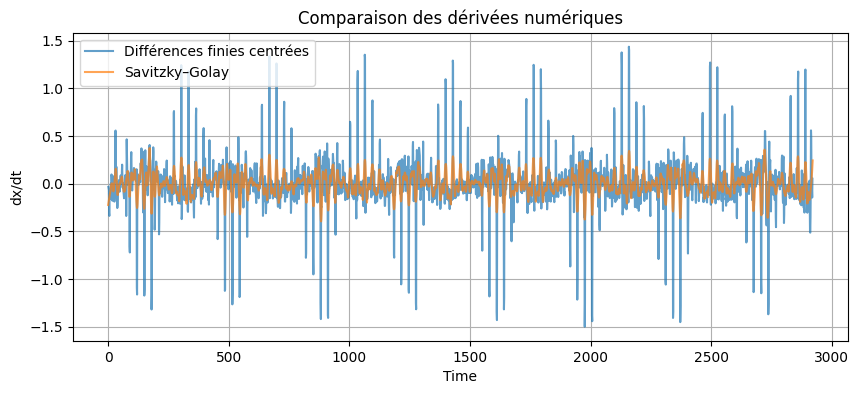

In [2]:
# Apply Savitzky–Golay filter to estimate a second time the derivative with less noise
# See https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html for more details about scipy's implementation

windowLength = 21 # Must be odd and greater than polyorder
polyorder = 3 # Polynomial order used for the local fitting

dxDtSg0 = savgol_filter(
    x0,
    window_length=windowLength,
    polyorder=polyorder,
    deriv=1,
    delta=dt,
)

dxDtSg1 = savgol_filter(
    x1,
    window_length=windowLength,
    polyorder=polyorder,
    deriv=1,
    delta=dt,
)

dxDtSg2 = savgol_filter(
    x2,
    window_length=windowLength,
    polyorder=polyorder,
    deriv=1,
    delta=dt,
)

tSg = t # Same length as original signal (time steps are unchanged)

plt.figure(figsize=(10, 4))
plt.plot(tFd, dxDtFd0, label="Différences finies centrées", alpha=0.7)
plt.plot(tSg, dxDtSg0, label="Savitzky–Golay", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Comparaison des dérivées numériques")
plt.legend()
plt.grid(True)
plt.show()


> #### Que fait le filtre de Savitzky-Golay ?

C'est un filtre numérique utilisé pour lisser des données bruitées tout en conservant la structure fine. C'est donc une bonne méthode à appliquer par dessus notre baseline.

Mathématiquement, cela consiste à ajuster localement un polynôme (de l'ordre *polyorder* choisi) par moindres carrés à chaque sous-ensembles de point de points adjacents du signal (conditionnés par *windowLength*), avant de calculer sa dérivée analytique (voir https://math.univ-cotedazur.fr/~diener/MAB07/MCO.pdf pour plus de détail sur la méthode des moindres carrés).

Voir la vidéo suivante pour une explication visuelle (https://www.youtube.com/watch?v=1SvDZPvUo_I).

### 2.3 Sensibilité au filtrage

On termine l'estimation par tester la sensibilité de celle-ci aux changements de paramètres de filtrage. On cherche simplement une cohérence pour s'assurer la stabilité numérique de la dynamique est bien posée.

Testons pour plusieurs fenêtres glissantes différentes à appliquer au filtrage.

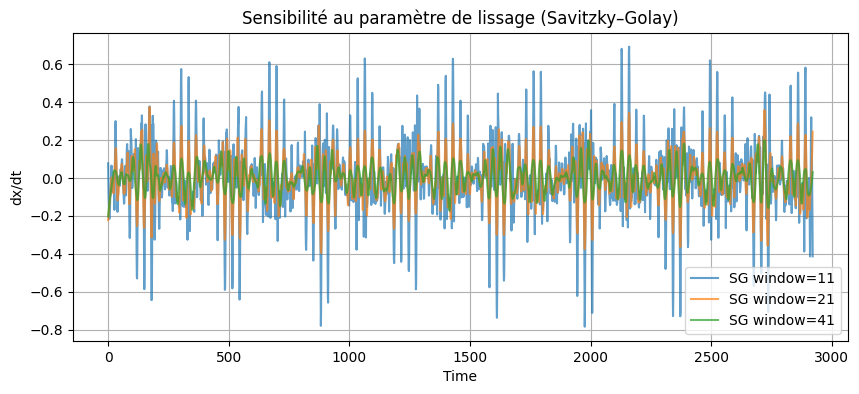

In [3]:
windows = [11, 21, 41]

plt.figure(figsize=(10, 4))

for w in windows:
    dx = savgol_filter(x0, window_length=w, polyorder=3, deriv=1, delta=dt)
    plt.plot(t, dx, label=f"SG window={w}", alpha=0.7)

plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Sensibilité au paramètre de lissage (Savitzky–Golay)")
plt.legend()
plt.grid(True)
plt.show()


On observe que les grandes structures temporelles sont communes aux trois courbes, correspondant à notre dynamique principale. 

Les différences portent sur l'amplitude et les hautes fréquences. Cela reste cohérent : plus on élargit la fenêtre plus le lissage du bruit est important.

Testons également avec un pas de temps différent.

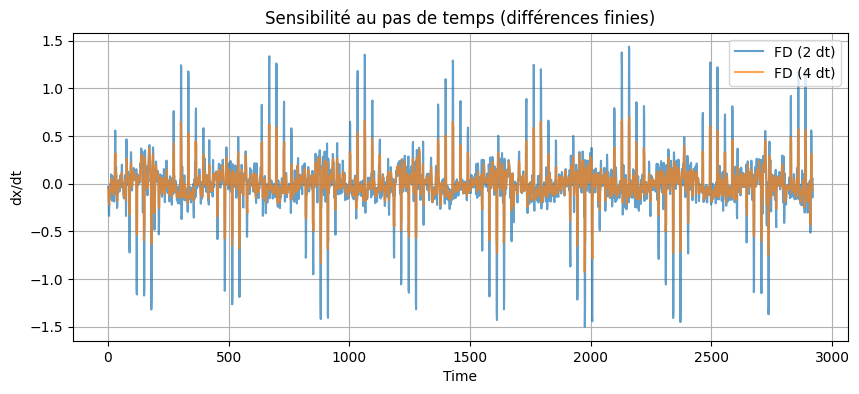

In [4]:
dxDtFdCoarse = (x0[4:] - x0[:-4]) / (4 * dt)
tFdCoarse = t[2:-2]

plt.figure(figsize=(10, 4))
plt.plot(tFd, dxDtFd0, label="FD (2 dt)", alpha=0.7)
plt.plot(tFdCoarse, dxDtFdCoarse, label="FD (4 dt)", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("dx/dt")
plt.title("Sensibilité au pas de temps (différences finies)")
plt.legend()
plt.grid(True)
plt.show()


Même constat pour le test avec un pas de temps plus important : bruits et amplitudes qui réduisent. On remarque que même avec le changement de pas il n'y a pas de rupture de régimes, les variations de pics se superposent.

En conclusion, le changement de paramètres n'affecte pas drastiquement la dynamique, les régimes ne changent pas subitement et les amplitudes ne s'effondrent ou n'explosent pas. Les dérivées sont sensibles mais cohérentes. La dynamique est présumée réelle et robuste, l'apprentissage d'un modèle SciML type Neural ODE sur notre état réduit semble donc pertinent.

&nbsp;

---

&nbsp;

## 3. Ordres de grandeur et cohérence physique

> #### Pourquoi analyser les ordres de grandeur ?

Un modèle d'apprentissage SciML, et plus particulièrement un réseau de neurones, est aveugle aux échelles physiques si les contraintes ne sont pas explicites. 

En clair, on peut faire apprendre toute dynamique numériquement correcte, mais si elle est absurde physiquement le modèle sera intrinsèquement faussé. Cela peut arriver si les dérivées sont trop grandes par rapport aux états ou si des dynamiques sont dominées par des fluctuations numériques.

Cette section visera donc à vérifier que les variables d'état et leur dérivées existent sur des échelles "compatibles" et temporellement stables.

&nbsp;

### 3.1 Amplitudes des dérivations

Les objets mathématiquement que l'on veut approximer avec nos futurs modèles SciML vivent par des normes et sur des échelles. L'une de ces règles d'apprenabilité est la condition de Lipschitz ($||\dot{x_1} - \dot{x_2}|| \leq L||x_1 - x_2||$). 

Sans trop rentrer dans les détails, ce que l'on veut c'est que notre champs de vecteur soit apprenable. Une des clés mathématiques pour diagnostiquer cette caractéristique c'est d'étudier comment évolue le champs de vecteur après dérivation (approximation dans notre cas). Le fin mot de l'hypothèse d'apprenabilité s'obtient en comparant l'avant et après dérivation (ou le ratio $ \frac{\dot{x}}{x}$). Si le ratio ($L$ dans notre condition de Lipschitz) est fini et raisonnable, l'hypothèse est validé proportionnellement au degré de respect du critère.

Si on commence par juste observer les histogrammes des classes primaires de notre vecteur, ce que l'on attend de voir ce sont des distributions où l'ordre de grandeur de la masse structurante décroît naturellement, ni trop longuement et ni trop brusquement.

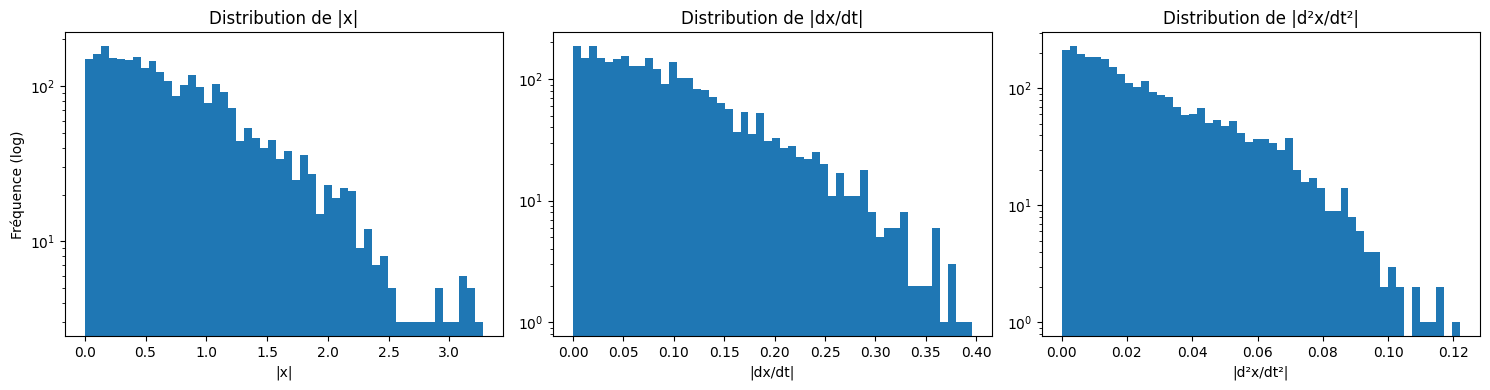

In [5]:
dxDt0 = dxDtSg0
d2xDt2 = np.gradient(dxDt0, dt)

dxDt1 = dxDtSg1
dxDt2 = dxDtSg2

# Reminder : x is a 1D array of shape (nTimeSteps,) because we selected only the first mode (modeId = 0)

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(np.abs(x0), bins=50, log=True)
plt.xlabel("|x|")
plt.ylabel("Fréquence (log)")
plt.title("Distribution de |x|")

plt.subplot(1, 3, 2)
plt.hist(np.abs(dxDt0), bins=50, log=True)
plt.xlabel("|dx/dt|")
plt.title("Distribution de |dx/dt|")

plt.subplot(1, 3, 3)
plt.hist(np.abs(d2xDt2), bins=50, log=True)
plt.xlabel("|d²x/dt²|")
plt.title("Distribution de |d²x/dt²|")

plt.tight_layout()
plt.show()


Ces distributions ne se lisent pas comme des distributions statistiques classiques, ils répondent plutôt à la question: "Sur quelles échelles de valeurs la dynamique évolue-t-elle ?". On parle donc plutôt de distribution d'échelle. 

Les deux informations majeures qu'on va traduire des histogrammes sont les valeurs qui structurent la dynamique (là où se situe la masse) et la dégradation de la masse structurante (la forme et la longueur de la pente, indiquant à quel point l'information de la valeurs dites "structurantes" se dégradent en s'éloignant de la masse de la distribution).

Les trois histogrammes montrent des signes sains d'une dynamique continue régularisée : 
- Les ordres de grandeur décroissent avec l'ordre de dérivation
- Pas de rupture, dérive ou explosion
- Pas de queue infinie

Le fait que la distribution pour le second ordre de dérivation garde une forme stable et cohérente laisse penser que le bruit est maîtrisé.

&nbsp;

### 3.2 Proportions des états

C'est ici qu'on détermine le ratio $ \frac{\dot{x}}{x}$ mentionné plus tôt. On cherche à ce la dynamique soit localement proportionnée à l’état, sans amplification brutale.

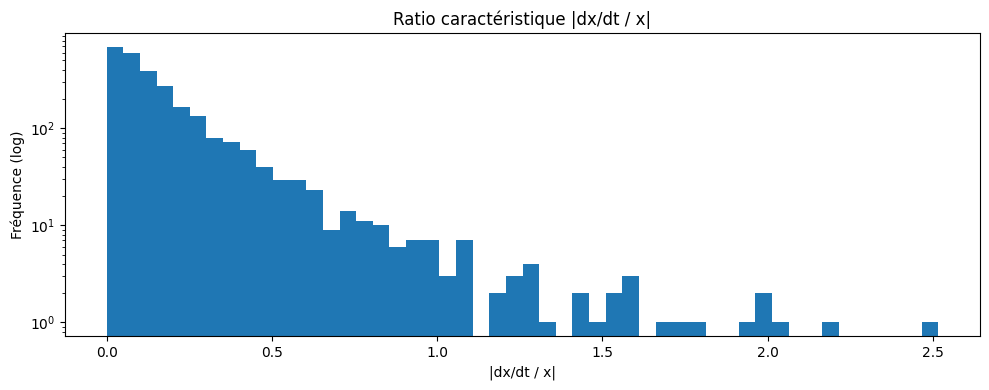

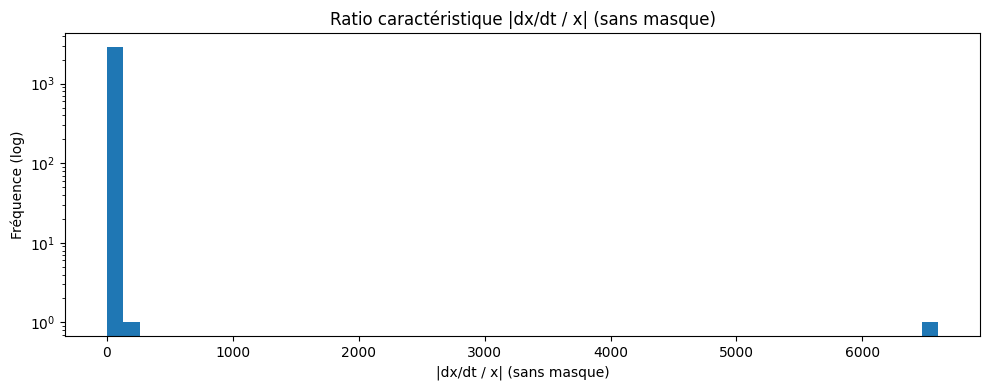

In [6]:
# Before this result, we tried :
# espilon = 1e-8
# ratio = np.abs(dxDt / (x + epsilon))

# We prefer using a mask to avoid artifacts due to division by very small values
maskRatio = np.abs(x0) > 0.1 * np.std(x0) # Avoid division by very small values so we dont get mathematical artifacts (huge ratios)
ratio = np.abs(dxDt0[maskRatio] / x0[maskRatio])
ratio2 = np.abs(d2xDt2[maskRatio] / dxDt0[maskRatio])

plt.figure(figsize=(10, 4))
plt.hist(np.abs(ratio), bins=50, log=True)
plt.xlabel("|dx/dt / x|")
plt.ylabel("Fréquence (log)")
plt.title("Ratio caractéristique |dx/dt / x|")
plt.tight_layout()
plt.show()

# Without masking, we get some huge values due to division by very small values of x
ratioNoMask = np.abs(dxDt0 / x0)
plt.figure(figsize=(10, 4))
plt.hist(np.abs(ratioNoMask), bins=50, log=True)
plt.xlabel("|dx/dt / x| (sans masque)")
plt.ylabel("Fréquence (log)")
plt.title("Ratio caractéristique |dx/dt / x| (sans masque)")
plt.tight_layout()
plt.show()


On observe une distribution proche de ce que l'on recherche. Une proportion localement saine du ratio caractéristique puis une dégradation progressive vers des rapports moins raisonnables (échelles moins représentatives de l'évolution de la dynamique approximée).

Sans le masque pour gérer les *outliers*, on constate la présence de quelques échelles extrêmes. Ils sont le fruit des quelques PCs qui s'écartent fortement de l'échelle majoritaire (ordre 1e-8, alors que certaines PCs sont de l'ordre 1e-10 voire 1e-11).

&nbsp;

### 3.3 Temps caractéristiques

Quand on parle de dynamique de systèmes, on ne cherche pas de valeurs précises mais plutôt à répondre à une question plus fondamentale :

> #### À quelle vitesse le système évolue-t-il ?

Et une question sous-jacente à la première, c'est que l'on va traiter dans cette partie, est :

> #### Sur combien de temps l'état change "significativement" ? Quelle est l'échelle temporelle naturelle du phénomène ?

On désigne cette "quantité" par le terme "temps caractérisque", soit une quantité de mesure dimensionnelle, locale, dynamique et indépendante de tout modèle précis.

Expliquer avec simplicité, un système continu suit la définition :

$$
\dot{x}(t) = f(x(t))
$$

À un instant donné, on peut approximer localement de la manière suivante :

$$
x(t+\Delta t) \approx x(t) + \dot{x}(t)\Delta t
$$

À partir de là, la dernière question qu'on se pose c'est :

> #### Combien de temps faut-il pour que $x$ change d’un ordre de grandeur comparable à lui-même ?

Autrement dit, on cherche $\tau$ tel que :

$$
|\dot{x}(t)|\tau \approx |x(t)|
$$

On trouve immédiatement le temps caractéristique, soit l'estimation du temps de variation relative unité, que l'on cherche à observer :

$$
\tau \approx |\frac{x(t)}{\dot{x}(t)}|
$$

On remarquera également que $\tau$ est l'inverse de notre précédent ratio caractéristique, nous devrions donc obtenir une forme de distribution "inverse" (mathématiquement) au ratio caractéristique précédemment observé.

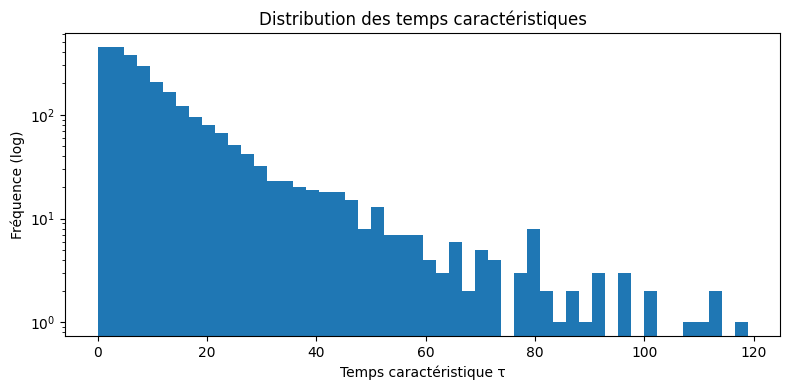

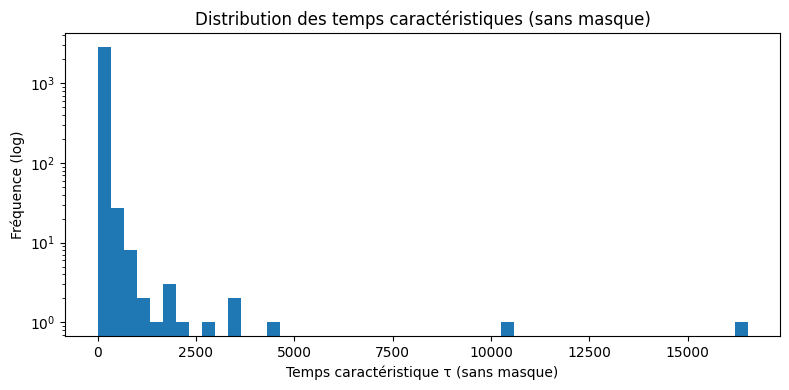

In [7]:
# Same here
maskTau = np.abs(dxDt0) > 0.1 * np.std(dxDt0) # we readjuste it to cut tau outliers
tau = np.abs(x0[maskTau] / dxDt0[maskTau])

plt.figure(figsize=(8, 4))
plt.hist(tau, bins=50, log=True)
plt.xlabel("Temps caractéristique τ")
plt.ylabel("Fréquence (log)")
plt.title("Distribution des temps caractéristiques")
plt.tight_layout()
plt.show()

# Without mask (for comparison)
tauNoMask = np.abs(x0 / dxDt0)
plt.figure(figsize=(8, 4))
plt.hist(tauNoMask, bins=50, log=True)
plt.xlabel("Temps caractéristique τ (sans masque)")
plt.ylabel("Fréquence (log)")
plt.title("Distribution des temps caractéristiques (sans masque)")
plt.tight_layout()
plt.show()


De manière similaire, on a éliminé les *outliers* via l'application d'un masque arbitrairement définie (peu important dans la mesure où on désire juste visualiser correctement le paramètre étudié).

La distribution des temps caractéristiques avec masque correspond assez bien à ce que l'on cherche :
- Une masse structurante clairement définie (avec une plage finie de $\tau$)
- Une décroissance progressive en *log-scale*
- Une queue relativement longue mais peu peuplé (sans divergences ou de masse à $+\infty$)

Dans notre cas, on a bien : 
- Un ensemble de temps caractéristiques "typiques" (une masse structurante)
- La présence de quelques phase plus lentes (une queue assez longue de temps caractéristique)
- Peu de valeurs extrêmes (avec le masque)

On peut émettre quelques réserves, car on monte à des $\tau$ relativement élevés (jusqu'à $\leq 100$), traduisant de phases quasi-stationnaires, mais c'est physiquement acceptable dans notre cas (et même assez normale pour un PC EOF).

&nbsp;

### 3.4 Échelles temporelles

> #### Ces échelles varient-elles brutalement dans le temps ou restent-elles stables ?

C'est la dernière question à laquelle on veut répondre concerant les ordres de grandeur. Étudions en fonction du temps le comportement des temps caractéristiques.

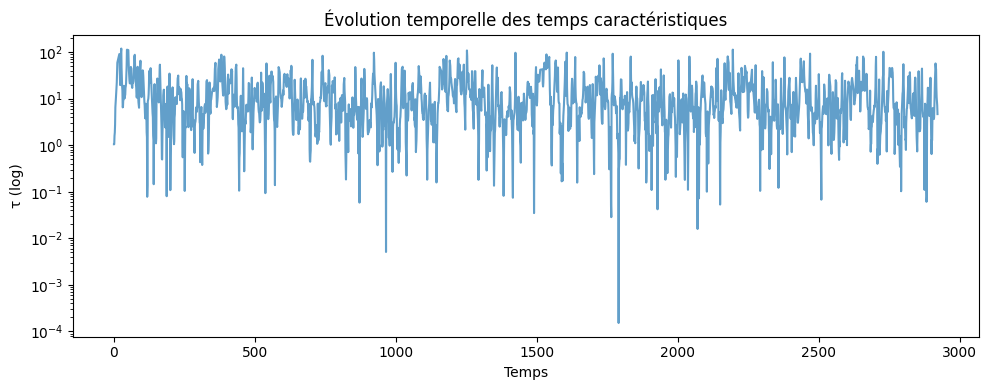

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(t[maskTau], tau, label="Temps caractéristique τ", alpha=0.7)
plt.yscale("log")
plt.xlabel("Temps")
plt.ylabel("τ (log)")
plt.title("Évolution temporelle des temps caractéristiques")
plt.tight_layout()
plt.show()


Globalement ce qu'on observe ici, c'est une dynamique qui alterne entre phases rapides et lentes, mais les échelles de temps restent relativement stables dans le temps.

On constate des fluctuations importantes mais de dérives ou de plateaux anormaux. Les extrêmes restent locaux, rares et non persistants.

&nbsp;

### 3.5 Traitement appliqué

Tout ce qu'on a constaté jusqu'à maintenant amène à penser que l'apprenabilité des PCs par un modèle SciML opérera dans de bonnes conditions de dynamique du système.

En revanche, on remarque une légère pathologie concernant les quelques valeurs extrêmes. Ce qu'il faut comprendre c'est qu'un modèle SciML ne sait pas vraiment faire la différence entre une singularité de coordonnées (une variabilité extrême numérique indésirable à l'apprentissage) et une singularité dynamique réelle (une réelle variabilité que l'on veut enseigner au modèle). 

L'idée serait donc de régulariser ces "bugs" au risque que les modèles SciML résultent sur des gradients hors échelle ou sur tout phénomène résultant d'un apprentissage instable. La dynamique est saine mis à part ces quelques singularités de coordonnées, une bonne stratégie serait donc réduire l'influence de ces points non-informatifs dans la *loss*.

&nbsp;

> #### Qu'est-ce que la *loss* ?

Cela correspond à la fonction de perte, une fonction qui va mesurer "à quel point le modèle se trompe". C'est le *seul* signal qu'un réseau neuronal reçoit pour apprendre. Le NN ajuste ses paramètres uniquement pour minimiser cette perte. Dans une régression classique, la *loss* correspond à : $\mathcal{L} = \frac{1}{N}\sum(y-\hat{y})²$.

&nbsp;

Dans notre cas la *loss* standard SciML (pour un ODE-NN par exemple) ressemble plus à :

$$
\mathcal{L}_\text{ODE} = \underset{t}{\sum} ||\dot{x}_\text{pred}(t) - \dot{x}_\text{obs}(t)||²
$$

Pour réduire l'influence sur la loss conditionnellement comme on le désire, on introduit un poids dynamique :

$$
\mathcal{L} = \underset{t}{\sum}\omega(t) ||\dot{x}_\text{pred}(t) - \dot{x}_\text{obs}(t)||²
$$

Le poids doit vérifier :
- $\omega(t) \approx 1$ quand $x(t)$ est "significatif"
- $\omega(t) \to 0$ quand $x(t) \to 0$

Le choix standard pour remplir ces conditions est : 

$$
\omega(t) = \frac{|x(t)|}{|x(t)| + \epsilon}
$$

&nbsp;

> Ce traitement sera appliqué en amont de la modélisation SciML car nous avons besoin des valeurs prédites pour la *loss*.

&nbsp;

---

&nbsp;

## 4. Visualisation du champs de phase

Jusqu'ici nous avions regardé des séries temporelles, des dérivées ou des échelles. Cette partie a pour rôle d'observer la structure géométrique du système, dans le but d'en tirer quelques indices pour la suite du pré-traitement et/ou le SciML.

&nbsp;

> #### La dynamique est-elle organisée dans l’espace des états ?

Si le système suit une dynamique, on devrait pouvoir observer une structure équilibrée, peut-être une forme géométrique ou un nuage centré sans fuite vers l'infini. 

Visualisons quelques *plots* caractéristiques de l'espace des états.

&nbsp;

### 4.1 Champs de phase simple

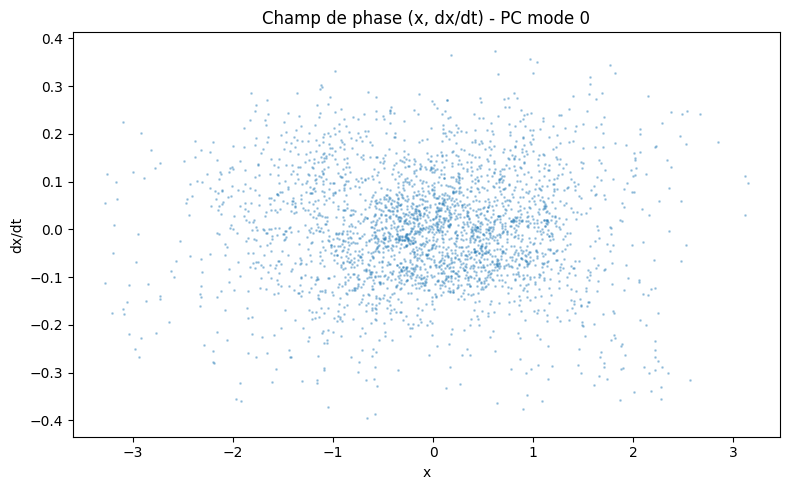

In [9]:
plt.figure(figsize=(8, 5))
plt.scatter(x0, dxDt0, s=1, alpha=0.3)
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.title("Champ de phase (x, dx/dt) - PC mode 0")
plt.tight_layout()
plt.show()


Ce qu'on observe dans ce premier plot c'est un nuage centrée avec une densité maximale au centre et sans fuite vers l'infini. La dérivé moyenne semble proche de 0. On peut également parler d'une symmétrie autour de $x=0$.

On ne remarque pas de structure géométrique évidente. Une dynamique dissipative mais bornée représentant une fluctuation d'un état moyen semble cohérent. Ne pas voir de cycle est déjà une information dynamique. Poursuivons.

&nbsp;

### 4.2 Champs de phase en fonction du temps

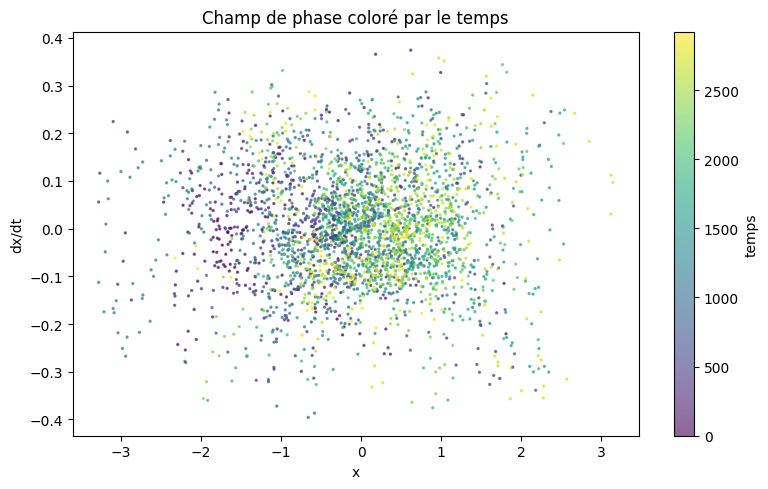

In [10]:
plt.figure(figsize=(8, 5))
sc = plt.scatter(
    x0,
    dxDt0,
    c=t,
    s=2,
    cmap="viridis",
    alpha=0.6
)
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.title("Champ de phase coloré par le temps")
plt.colorbar(sc, label="temps")
plt.tight_layout()
plt.show()


Ici ce qui est important de remarquer c'est l'abscence d'un gradient temporel évident. Cela signifie que notre système ne *shift* pas de régime vers un autre attracteur au cours du temps. La dynamique est donc présumée stationnaire à grande échelle.

&nbsp;

### 4.3 Densité du champ de phase

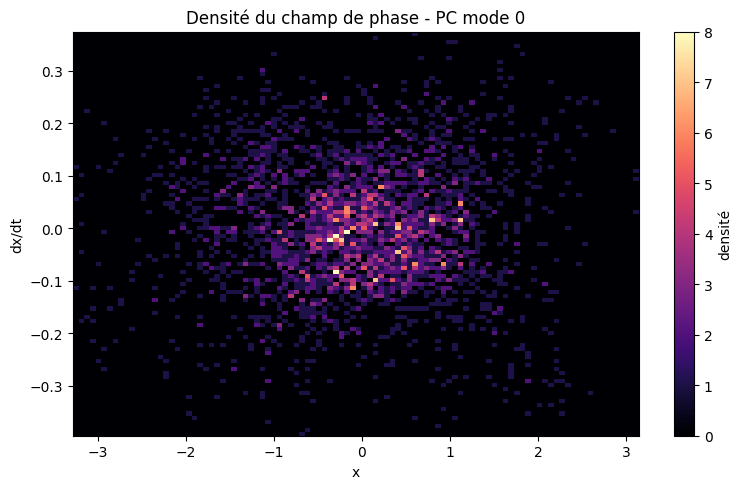

In [11]:
plt.figure(figsize=(8, 5))
plt.hist2d(x0, dxDt0, bins=100, cmap="magma")
plt.xlabel("x")
plt.ylabel("dx/dt")
plt.title("Densité du champ de phase - PC mode 0")
plt.colorbar(label="densité")
plt.tight_layout()
plt.show()


Ce *plot* confirme totalement nos premières observations de phase. On observe une densité maximale au centre et la masse structurante est compacte. On remarque également une décroissance radiale progressive (densité diminuant proportionnellement à l'éloignement de la masse centrale). Absence de bras ou de vides internes/externes (symmétrie centrale propre).

Nous avons bien à faire à un **attracteur**, assez **diffus** mais **confiné**.

&nbsp;

### 4.4 Champ de phase des modes secondaires

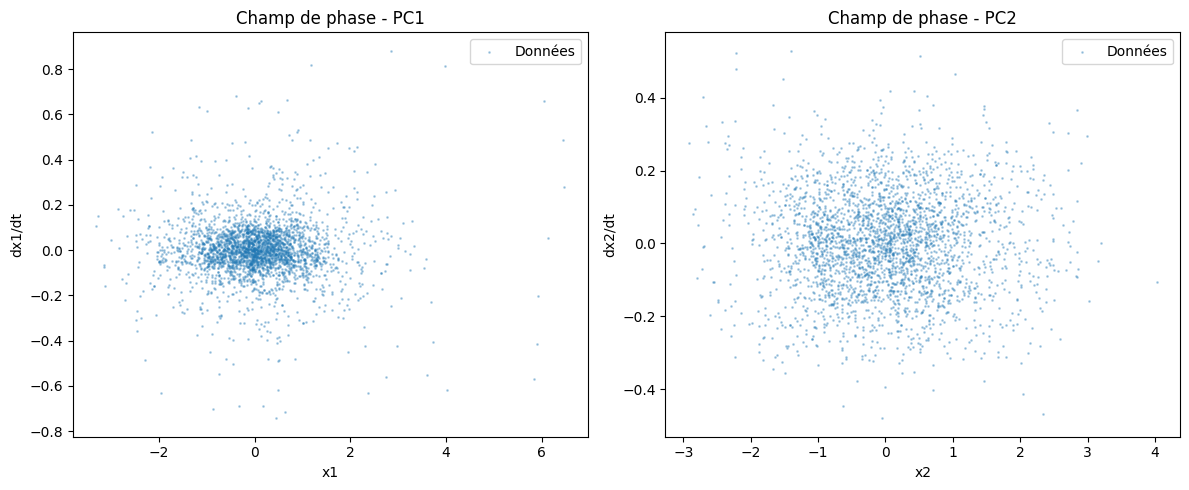

In [12]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(x1, dxDt1, s=1, alpha=0.3, label="Données")
plt.xlabel("x1")
plt.ylabel("dx1/dt")
plt.title("Champ de phase - PC1")
plt.legend()
plt.tight_layout()

plt.subplot(1, 2, 2)
plt.scatter(x2, dxDt2, s=1, alpha=0.3, label="Données")
plt.xlabel("x2")
plt.ylabel("dx2/dt")
plt.title("Champ de phase - PC2")
plt.legend()
plt.tight_layout()

plt.show()


Même constat si on visualise le champ de phase des modes suivants, certaines caractéristiques varient au cas par cas. 

PC1 est plus compacte avec quelques amplitudes singulières qui s'écartent assez de la masse structurante de manière asymmétrique (plus d'amplitudes extrêmes dans les positifs).

PC2 ressemble fortement à PC0 avec une légère asymmétrie vers les amplitudes positifs éloignées de la masse centrale.

&nbsp;

### 4.5 Interprétations et remarques

> #### Que peut-on conclure de ces observations ?

Les champs de phase ne révèlent pas de structures géométriques simples telles que des cycles limites ou des spirales bien définies. En revanche, la dynamique apparaît clairement confinée dans l’espace des états, avec une densité maximale autour d’une région centrale et une décroissance progressive vers les amplitudes plus élevées.

Cette organisation est caractéristique d’une **dynamique dissipative** soumise à des forçages et des fluctuations, plutôt que d’un système déterministe de faible dimension.

Ce qu'il faut retenir pour la modélisation SciML, c'est que l'absence d'un "joli" cycle pour un nuage structuré indique un système plus riche/complexe. Cela nous informe sur quel type de SciML n'est probablement pas pertinent, un ODE déterministe par exemple.

Indirectement cela nous dirige vers des modèles qui pourraient être pertinents :

- un Neural ODE régularisé
- un modèle latent avec bruit/forçage
- un UDE (Universal Differential Equation)

&nbsp;

---

&nbsp;

## 5. Conclusions

Les analyses menées montrent que :

- les dérivées temporelles, une fois régularisées, sont bien définies et cohérentes,
- les ordres de grandeur et les temps caractéristiques sont stables et compatibles avec une dynamique continue,
- la dynamique observée est confinée dans l’espace des états, sans attracteur géométrique simple ni transition franche de régime.

Ces résultats indiquent que la dynamique sous-jacente est bien posée, mais diffuse, et qu’elle ne se réduit pas à un système déterministe simple de faible dimension.

Ce diagnostic valide l’usage de modèles SciML contraints par la dynamique, tout en soulignant la nécessité d’intégrer des mécanismes de régularisation et de prise en compte des échelles identifiées. Le choix précis des architectures et des formulations de perte sera abordé dans un notebook de synthèse dédié.

&nbsp;

> #### Ce notebook n’a pas modifié le vecteur d'état.